In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

读取

In [9]:
def load_tweets_data(name): 
    csv_path = os.path.join("./twitter_cleaned/", name) 
    return pd.read_csv(csv_path)

tweets = load_tweets_data("train_posts.csv")

去除无关列，只留event timestamp label，更新event列信息

In [10]:
tweets.drop(["post_text"],axis=1,inplace=True)
tweets.drop(["post_id"],axis=1,inplace=True)
tweets.drop(["user_id"],axis=1,inplace=True)
tweets.drop(["username"],axis=1,inplace=True)

# 修改更新event列
split_result = tweets['image_id'].str.split('_',expand=True)
tweets.insert(0, 'event', split_result[0])
tweets.drop(["image_id"],axis=1,inplace=True)

取出timestamp，处理格式

In [11]:
# 分别取出年月日
split_time = tweets['timestamp'].str.split(' ',expand=True)
split_time = split_time.iloc[:,[5,1,2]]

# 将月的格式进行转换
dict_month = {'Jan':'1','Feb':'2','Mar':'3','Apr':'4','May':'5','Jun':'6',
              'Jul':'7','Aug':'8','Sep':'9','Oct':'10','Nov':'11','Dec':'12'}
data = []
for index, value in split_time[1].items():
    data.append(dict_month.get(value))

# 插入转换后的列，删除原列，更改列索引名
split_time.insert(1, 'time', data)
split_time.drop([1],axis=1,inplace=True)
split_time.columns=['year','month','day']

# 合并成一列
split_time["time_month"] = split_time["year"] +'.'+ split_time["month"]+'.'+ split_time["day"]

# 删除子列，只留合并后的列
split_time.drop(["year"],axis=1,inplace=True)
split_time.drop(["month"],axis=1,inplace=True)
split_time.drop(["day"],axis=1,inplace=True)

# 插入格式正确的时间列
norm_data = pd.concat([tweets,split_time], axis=1)
norm_data.drop(["timestamp"],axis=1,inplace=True)
norm_data.head()

,event,label,time_month
0,boston,fake,2013.4.17
1,boston,fake,2013.4.19
2,boston,fake,2013.4.19
3,boston,fake,2013.4.17
4,boston,fake,2013.4.17


norm_data为最终格式，查看数据集整体情况

In [16]:
event = norm_data.event.unique()
print(event,len(event))
norm_data['event'].value_counts()

['boston' 'malaysia' 'passport' 'sandy' 'sochi' 'bringback'
 'columbianChemicals' 'elephant' 'livr' 'pigFish' 'underwater' 'eclipse'
 'samurai' 'nepal' 'garissa'] 15


sandy                 9818
nepal                 1360
boston                 523
malaysia               310
eclipse                275
sochi                  274
samurai                218
columbianChemicals     185
bringback              131
underwater             113
garissa                 79
passport                44
pigFish                 14
elephant                13
livr                     9
Name: event, dtype: int64

取出某一事件，时序变化特征

In [26]:
# 取出特定时间的推文和时间戳
one_event = norm_data.loc[norm_data['event'] == 'boston']
time = one_event.time_month.unique()

# 插入时间为key
dict_event = {}
dict_event = {}.fromkeys([ti for ti in time])

# 插入真假类别为子key 
class_event = ['real', 'fake']
for key in dict_event.keys():
    dict_event[key] = {}.fromkeys([key for key in class_event])

# 向字典框架填入数量
for index, row in one_event.iterrows():
    if dict_event[row['time_month']][row['label']] == None:
        dict_event[row['time_month']][row['label']] = 1
    else:
        dict_event[row['time_month']][row['label']] += 1

# 按日期排序
dict_event = dict(sorted(dict_event.items(), key=lambda x: x[0]))

# 转为dataframe并反转
df_event = pd.DataFrame(dict_event).T
df_event

,real,fake
2013.4.16,NaN,3.0
2013.4.17,NaN,105.0
2013.4.18,51.0,26.0
2013.4.19,241.0,39.0
2013.4.20,48.0,6.0
2013.4.22,2.0,NaN
2013.4.23,1.0,NaN
2013.4.24,1.0,NaN


可视化

<AxesSubplot:>

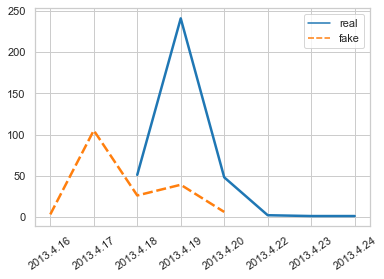

In [34]:
sns.set_theme(style="whitegrid")
plt.xticks(rotation=35) 
sns.lineplot(data=df_event, palette="tab10", linewidth=2.5)